# MLE - Exercise 4 - More Comparative Experimentation
## Andreas Kocman (se19m024)

## Assignment
This exercise follows very much the style of the previous exercise - you shall do experiments with different data sets and classifiers. Again, you can do the exercise alone, or in a group of two.

The datasets to use are
* The datasets from the exercise 3, i.e. Iris, Optical Digits (and if you are in a group, then also Breast Cancer)
* Either the music or the image data set - decided by your matriculation number modulo 2, 0 means music, 1 means image (If you are doing this exercise in a group, then you shall take both data sets)

The classifiers & parameters to use are
* All the classifiers & parameters from exercise 3
* Decision trees, you shall have two setups: one fully grown tree, and one setting for a pruned or pre-pruned tree.
   * (If you are a group, you shall try a total of four settings: two unpruned trees using two different split criteria, and two setups for different amounts of (pre)-pruning the tree.)
* Random Forests, using two different settings for the number of trees
   * (If you are in a group, also vary the number of attributes that are used in each split; use three different values resp. computation methods (sqrt, log, fraction, ...); this should give you a total of 6 runs: (2 number of trees) x (3 number of attributes))
* SVMs: just use the default settings, but use both SVC and LinearSVC classifiers (http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html, http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

### Image Dataset
We will use the "Fruit Image Dataset", originally provided at http://data.vicos.si/datasets/FIDS30/, but with an edited version linked from Moodle (some images had an encoding not compatible with e.g. python libraries). Your task is to classify images into the category of fruit (a total of 30 defined categories) they belong to.

As this is image data, feature extraction is a requirement before we can actually learn anything. As you shouldn't spend too much time on that, there is demo code on how to work with this data available, linked from the course main page.

This code generates a set of 4 different features, all rather simple and based on histograms of colours (i.e. counts on how often a certain colour appears). You shall work with all four of them, and likely will see very different results.

### Music Dataset
We will use the dataset provided by George Tzanetakis, called "gtzan". This dataset contains 1.000 songs, 100 songs for 10 genres, and the task is therefore to predict the genres of a song; to limit file size, the songs are only 30 second snippets, and sampled with 22 khz only. You can download the dataset from the Moodle main page, or also at at http://kronos.ifs.tuwien.ac.at/GTZANmp3_22khz.zip. As this is copyrighted materials, please do not redistribute it...!

As this is audio data, feature extraction is a requirement before we can actually learn anything. Therefore, there is demo code on how to work with this data available, linked from the course main page.

This code generates different features, very simple ones containing just BeatsPerMinute, to more advanced ones based on advanced signal processing.  You shall work with all of them, and likely will see very different results.

### Working in a group
If you work in a group, as partially written above, your scope will be extended

* More datasets: both music & image datasets
* More parameter variations
* More evaluation: for the Music&Image datasets, you shall also add an analysis of the confusion matrix for these datasets. It is sufficient, to provide one confusion matrix per feature set, you can select either the best classifier that you had on that feature set, or also other interesting ones.

### Links for python
* http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

### Non-python feature extractors
#### Java
* For images, you can use a port of openCV, the OpenCV bindings (http://docs.opencv.org/2.4/doc/tutorials/introduction/desktop_java/java_dev_intro.html) or a different implementation in  Java: https://github.com/bytedeco/javacv. The sample code should then be quite similar to the one in python.
* For music: http://jmir.sourceforge.net/index_jAudio.html (the jAudio component) offers a GUI for extracting features, best is to use BPM (strongest beat), MFCCs and Chroma, and their derivatives, i.e. the statistics that are also used in the sample code. jAudio should be able to generate ARFF files for WEKA.

#### C#
* For image, you should find OpenCV bindings as well for C#

## Sources used
* Scikit documentation

## Solution

### Introduction
#### Datasets to Use
Matriculation number: SE19M024%2 = 0 - using music dataset

#### Reporting
Since descriptive analysis and classification of the Scikit Iris and Digits dataset were already covered in detail in the course of exercise 2, the following will focus especially on
* new analysis of the Iris and Digits datasets, namely:
   * SVMs
   * Pruned decision trees
   * Random forests
* additionally, descriptive analysis of the new datasets yielded from feature extraction of 1000 mp3s
* as well as classification of the resulting datasets using the classifiers mentioned in the exercise description

For descriptive analysis of the Iris and Digits datasets as well as the classifications covered in the course of exercise 2, results will be reported, but no additional interpretation in prose will be provided. For interpretation, please see exercise 2.

### Helper Functions for Solution and Data Analysis

In [41]:
# global Imports
import pandas as pd
import numpy as np

#sk learn imports
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

#Data reporting
from IPython.display import display
import matplotlib.pyplot as plt

# Global definitions:
averaging_approach = 'macro'
zero_division_approach = 0
number_of_folds = 5
scoring = {'Accuracy': make_scorer(accuracy_score),
            'Precision': make_scorer(precision_score, average=averaging_approach, zero_division=zero_division_approach),
            'Recall': make_scorer(recall_score, average=averaging_approach, zero_division=zero_division_approach)}

# Helper functions
def parse_k_fold_results(results):
    return "m: " + str(np.average(results)) + " std: " + str(np.std(results))

def parse_argument_tuple_as_string(argumentsTuple):
    return "max Depth: " + str(argumentsTuple[0])  + \
           ", min Samples: " + str(argumentsTuple[1])

def calculate_results_cross_validate(dataset_name, classifier_used, classifier_name, data, target):
   scores = cross_validate(classifier_used, data, target,
                                scoring = scoring,
                                cv = number_of_folds,
                                error_score = 0,
                                n_jobs = 4)

   return pd.Series({
            'dataset': dataset_name,
            'classifier': classifier_name,
            'arguments': str(classifier_used),
            'mean_accuracy': np.average(scores.get('test_Accuracy')),
            'mean_precision': np.average(scores.get('test_Precision')),
            'mean_recall': np.average(scores.get('test_Recall')),
            'accuracy': parse_k_fold_results(scores.get('test_Accuracy')),
            'precision': parse_k_fold_results(scores.get('test_Precision')),
            'recall':parse_k_fold_results(scores.get('test_Recall'))
        })

def print_results(array, column_for_max, ascending=False):
    df = pd.DataFrame(array)
    df = df.sort_values(by=[column_for_max], ascending=False)
    display('Results', df)

    best = df.iloc[df[column_for_max].argmax()]
    display(best)


### Dataset Extraction Music

In [5]:
# We need to construct our data set; unfortunately, we don't simply have a "loadGTZanDataSet()" function in SK-learn...
# So we need to
## Download our data set & extract it (one-time effort)
## Run an audio feature extraction
## Create the create the ground truth (label assignment, target, ...)

# path to our audio folder
# For the first run, download the images from http://kronos.ifs.tuwien.ac.at/GTZANmp3_22khz.zip, and unzip them to your folder
imagePath="/tmp/mp3/"

# Find all songs in that folder; there are like 1.000 different ways to do this in Python, we chose this one :-)
import glob, os
print(os.getcwd())
os.chdir(imagePath)
fileNames = glob.glob("*/*.mp3")
numberOfFiles=len(fileNames)
targetLabels=[]

print ("Found " + str(numberOfFiles) + " files\n")

# The first step - create the ground truth (label assignment, target, ...)
# For that, iterate over the files, and obtain the class label for each file
# Basically, the class name is in the full path name, so we simply use that
for fileName in fileNames:
    pathSepIndex = fileName.index("/")
    targetLabels.append(fileName[:pathSepIndex])

# sk-learn can only handle labels in numeric format - we have them as strings though...
# Thus we use the LabelEncoder, which does a mapping to Integer numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(targetLabels) # this basically finds all unique class names, and assigns them to the numbers
print ("Found the following classes: " + str(list(le.classes_)))

# now we transform our labels to integers
musicTarget = le.transform(targetLabels);
print ("Transformed labels (first elements: " + str(musicTarget[0:150]))

# If we want to find again the label for an integer value, we can do something like this:
# print list(le.inverse_transform([0, 18, 1]))
print ("... done label encoding")

/tmp/mp3
Found 1000 files

Found the following classes: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Transformed labels (first elements: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8]
... done label encoding


In [6]:
# Now we do the actual feature extraction
from librosa import display
import librosa
import datetime
from collections import deque
import warnings

import numpy as np
import scipy.stats.stats as st

warnings.filterwarnings("ignore", message = 'PySoundFile failed. Trying audioread instead.')

# This is a helper function that computes the differences between adjacent array values
def differences(seq):
    iterable = iter(seq)
    prev = next(iterable)
    for element in iterable:
        yield element - prev
        prev = element

# This is a helper function that computes various statistical moments over a series of values, including mean, median, var, min, max, skewness and kurtosis (a total of 7 values)
def statistics(numericList):
    return [np.mean(numericList), np.median(numericList), np.var(numericList), np.float64(st.skew(numericList)), np.float64(st.kurtosis(numericList)), np.min(numericList), np.max(numericList)]



print ("Extracting features using librosa" + " (" + str(datetime.datetime.now()) + ")")

# compute some features based on BPMs, MFCCs, Chroma
data_bpm=[]
data_bpm_statistics=[]
data_mfcc=[]
data_chroma=[]

for indexSample, fileName in enumerate(fileNames):
    # Load the audio as a waveform `y`, store the sampling rate as `sr`
    y, sr = librosa.load(fileName)

    # run the default beat tracker
    tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
    # from this, we simply use the tempo as BPM feature
    data_bpm.append([tempo])

    # Then we compute a few statistics on the beat timings
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    # from the timings, compute the time differences between the beats
    beat_intervals = np.array(deque(differences(beat_times)))

    # And from this, take some statistics
    # There might be a few files where the beat timings are not determined properly; we ignore them, resp. give them 0 values
    if len(beat_intervals) < 1:
        print ("Errors with beat interval in file " + fileName + ", index " + str(indexSample) + ", using 0 values instead")
        data_bpm_statistics.append([tempo, 0, 0, 0, 0, 0, 0, 0])
    else:
        bpm_statisticsVector=[]
        bpm_statisticsVector.append(tempo) # we also include the raw value of tempo
        for stat in statistics(beat_intervals):  # in case the timings are ok, we actually compute the statistics
            bpm_statisticsVector.append(stat) # and append it to the vector, which finally has 1 + 7 features
        data_bpm_statistics.append(bpm_statisticsVector)

    # Next feature are MFCCs; we take 12 coefficients; for each coefficient, we have around 40 values per second
    mfccs=librosa.feature.mfcc(y=y, sr=sr, n_mfcc=12)
    mfccVector=[]
    for mfccCoefficient in mfccs: # we transform this time series by taking again statistics over the values
        mfccVector.append(statistics(mfccCoefficient))

    # Finally, this vector should have 12 * 7 features
    data_mfcc.append(np.array(mfccVector).flatten())


    # Last feature set - chroma (which is roughly similar to actual notes)
    chroma=librosa.feature.chroma_stft(y=y, sr=sr)
    chromaVector=[]
    for chr in chroma: # similar to before, we get a number of time-series
        chromaVector.append(statistics(chr)) # and we resolve that by taking statistics over the time series
    # Finally, this vector should be be 12 * 7 features
    data_chroma.append(np.array(chromaVector).flatten())

print (".... done" + " (" + str(datetime.datetime.now()) + ")")

# Finally, we do classification
# These are our feature sets; we will use each of them individually to train classifiers
trainingSets = [data_bpm, data_bpm_statistics, data_chroma, data_mfcc ]

/home/andi/PycharmProjects/tw_mle_exercise4/venv/lib64/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/andi/PycharmProjects/tw_mle_exercise4/venv/lib64/python3.8/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Extracting features using librosa (2020-06-14 16:11:36.455790)
Errors with beat interval in file classical/classical.00050.mp3, index 849, using 0 values instead
.... done (2020-06-14 16:27:37.728904)


### Calculation Functions


#### k-NN Calculation

In [7]:
from sklearn import neighbors

def calculate_knn(dataset_name, data, target):
    knn_results = []

    n_neighbors = range(1,10,1)

    for n in n_neighbors:
        knn_classifier = neighbors.KNeighborsClassifier(n)
        description = "N = " + str(n)
        result = calculate_results_cross_validate(dataset_name,
                                                  knn_classifier,
                                                  "knn",
                                                  data,
                                                  target)
        knn_results.append(result)
    return knn_results


#### Bayes Calculation

In [8]:
from sklearn import naive_bayes

def calculate_bayes(dataset_name, data, target):
    bayes_results = []

    classifier = naive_bayes.CategoricalNB()
    result = calculate_results_cross_validate(dataset_name,
                                              classifier,
                                              "bayes",
                                              data,
                                              target)
    bayes_results.append(result)

    return bayes_results

#### Perceptron Calculation

In [9]:
from sklearn import linear_model

def calculate_perceptron(dataset_name, data, target):
    perceptron_results=[]
    classifier = linear_model.Perceptron()
    result = calculate_results_cross_validate(dataset_name,
                                              classifier,
                                              "perceptron",
                                              data,
                                              target)
    perceptron_results.append(result)
    return perceptron_results

#### Decision Tree Calculation

In [10]:
from sklearn.tree import DecisionTreeClassifier

def calculate_decision_tree(dataset_name, data, target):
    # Parameters for the decision tree
    classifiers = [
        DecisionTreeClassifier(),
        DecisionTreeClassifier(max_depth = 5),
        DecisionTreeClassifier(min_samples_leaf = 50)
        ]
    decision_tree_results = []

    for classifier in classifiers:
        result = calculate_results_cross_validate(dataset_name,
                                                  classifier,
                                                  "decision tree",
                                                  data,
                                                  target)
        decision_tree_results.append(result)
    return decision_tree_results

##### Additional Analysis of the Effects of Prunint on Decision Trees

In [11]:
from sklearn.tree import DecisionTreeClassifier

def calculate_decision_tree_pruning_effect(dataset_name, data, target):
    # Parameters for the decision tree

    pruning_sizes = range(1,50,1)
    decision_tree_results = []

    for pruning_size in pruning_sizes:
        classifier = DecisionTreeClassifier(max_depth = pruning_size)
        result = calculate_results_cross_validate(dataset_name,
                                                  classifier,
                                                  "decision tree",
                                                  data,
                                                  target)
        decision_tree_results.append(result)
    return pd.DataFrame(decision_tree_results)

#### Random Forest Calculation

In [12]:
from sklearn.ensemble import RandomForestClassifier

def calculate_random_forest(dataset_name, data, target):

    # Split the data into training and testing sets
    train_X, test_X, train_Y, test_Y = train_test_split(data, target, test_size = 0.33)
    # Parameters for the random forest
    arguments = range(10,200,50)
    random_forest_results = []

    for argument in arguments:
        classifier = RandomForestClassifier(n_estimators = argument)
        classifier.fit(train_X, train_Y)
        test_Y_predicted = classifier.predict(test_X)
        precision = metrics.precision_score(test_Y, test_Y_predicted, average = "micro")
        accuracy = metrics.accuracy_score(test_Y, test_Y_predicted)

        random_forest_results.append(pd.Series({
            'dataset': dataset_name,
            'classifier': "Random Forest",
            'arguments': str(classifier),
            'mean_accuracy': accuracy,
            'mean_precision': precision,
            'mean_recall': "-",
            'accuracy': "-",
            'precision': "-",
            'recall': "-"
        }))

    return random_forest_results

#### SVM Calculation

In [13]:
from sklearn import svm
from sklearn import preprocessing

def calculate_svm(dataset_name, data, target):
    svm_results = []

    classifiers = [
        svm.SVC(max_iter = 10000),
        svm.LinearSVC(max_iter = 10000)
    ]

    scaler = preprocessing.StandardScaler()
    data = scaler.fit_transform(data)

    for classifier in classifiers:
        result = calculate_results_cross_validate(dataset_name,
                                                  classifier,
                                                  "svm",
                                                  data,
                                                  target)
        svm_results.append(result)
    return svm_results

## Load Datasets

In [16]:
from sklearn import datasets as sk_datasets
from IPython.display import display

# Iris and Digits
iris = sk_datasets.load_iris()
digits = sk_datasets.load_digits()

# Music Datasets have already been loaded into the trainingSets array

# Generate unified array of dataset information to facilitate subsequent analysis
datasets = [{'name': 'iris', 'data': iris.data, 'target': iris.target},
            {'name': 'digits', 'data': digits.data, 'target': digits.target},
            {'name': 'data_bpm', 'data': trainingSets[0], 'target': musicTarget},
            {'name': 'data_bpm_statistics', 'data': trainingSets[1], 'target': musicTarget},
            {'name': 'data_chroma', 'data': trainingSets[2], 'target': musicTarget},
            {'name': 'data_mfcc', 'data': trainingSets[3], 'target': musicTarget}]

## Descriptive Analysis

### Iris Dataset
Descriptive analysis of the Iris dataset has already been done as part of exercise 2. An exhaustive analysis can either be found there or [here](https://en.wikipedia.org/wiki/Iris_flower_data_set).

In [17]:
df = pd.DataFrame(datasets[0]['data'], columns=iris.feature_names)
display("Data", df.describe())

df = pd.DataFrame(datasets[0]['target'])
display("Target Frequencies", df[0].value_counts().sort_index())


'Data'

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


'Target Frequencies'

0    50
1    50
2    50
Name: 0, dtype: int64

### Digits Dataset
Descriptive analysis of the Digits dataset has already been done as part of exercise 2. An exhaustive analysis can either be found there or [here](https://en.wikipedia.org/wiki/MNIST_database).

In [18]:
df = pd.DataFrame(datasets[1]['data'], columns=digits.feature_names)
display("Data", df.describe())

df = pd.DataFrame(datasets[1]['target'])
display("Target Frequencies", df[0].value_counts().sort_index())


'Data'

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,3.725097,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,4.919406,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,7.000000,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,16.000000,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000


'Target Frequencies'

0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
Name: 0, dtype: int64

### MP3 Dataset
The GTZAN Dataset consists of 30 second snippets 1000 songs, split into 10 genres with each 100 songs. The dataset has been the basis of [several publications](https://webhome.cs.uvic.ca/~gtzan/work/projects/pastc.html).
The genres are:
* Blues
* Classical
* Country
* Disco
* Hip Hop
* Jazz
* Metal
* Pop
* Reggae
* Rock

Based on the dataset, 4 approaches of feature extraction were used.
* Beats per Minute
* Statistics of Beats per Minute
* Chroma Analysis (resembling to actual music notes)
* [Mel Frequency Cepstral Coefficients/MFCCs](https://de.wikipedia.org/wiki/Mel_Frequency_Cepstral_Coefficients)

#### Beats Per Minute
Beats per Minute is the result of the `librosa.beat.beat_track` analysis.

In [19]:
labels = set(targetLabels)
display ('Labels', labels)
df = pd.DataFrame(datasets[3]['data'])

# overall analysis , columns = targetLabels
#df = le.inverse_transform(df[0])
display("Data overall", df.describe())

# per group analysis
display("Data Per Group", df.groupby(datasets[3]['target'], as_index=True, squeeze=True).describe())

# Target
df = pd.DataFrame(datasets[3]['target'])
display("Target Frequencies", df[0].value_counts().sort_index())

'Labels'

{'blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock'}

'Data overall'

,0,1,2,3,4,5,6,7
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,118.858171,0.532604,0.532608,0.000562,0.236626,4.468547,0.481071,0.594361
std,27.771299,0.128879,0.129129,0.000641,1.713201,6.446934,0.119005,0.154088
min,58.726918,0.000000,0.000000,0.000000,-6.641254,-1.998925,0.000000,0.000000
25%,99.384014,0.444793,0.441179,0.000193,-0.718948,0.187411,0.394739,0.487619
50%,117.453835,0.515190,0.510839,0.000349,0.061980,2.068265,0.464399,0.580499
75%,135.999178,0.608677,0.603719,0.000664,0.994833,6.505327,0.534059,0.673379
max,234.907670,1.088551,1.114558,0.006096,6.012872,44.370614,0.998458,1.369977


'Data Per Group'

0                                                            \
   count        mean        std        min         25%         50%   
0  100.0  118.879066  31.416175  58.726918   92.285156  117.453835   
1  100.0  125.680955  32.024360  67.999589   99.384014  123.046875   
2  100.0  110.295268  30.451738  60.092660   86.132812  112.347147   
3  100.0  120.388610  14.189647  86.132812  112.347147  123.046875   
4  100.0  113.052140  26.731105  71.777344   95.703125  103.359375   
5  100.0  116.534332  30.445384  61.523438   99.384014  110.006581   
6  100.0  124.969322  24.365002  61.523438  107.666016  123.046875   
7  100.0  110.892311  23.148238  58.726918   95.703125  107.666016   
8  100.0  129.183298  30.277850  73.828125   99.384014  129.199219   
9  100.0  118.706407  24.107550  73.828125  103.359375  117.453835   

                               1            ...         6                7  \
          75%         max  count      mean  ...       75%       max  count   
0  137.888055  198.768029  100.0  0.544115  ...  0.557279  0.998458  100.0   
1  145.665786  234.907670  100.0  0.503515  ...  0.510839  0.789478  100.0   
2  130.899208  198.768029  100.0  0.587142  ...  0.650159  0.905578  100.0   
3  129.199219  184.570312  100.0  0.505630  ...  0.510839  0.673379  100.0   
4  117.453835  198.768029  100.0  0.553937  ...  0.557279  0.719819  100.0   
5  130.899208  215.332031  100.0  0.548505  ...  0.534059  0.835918  100.0   
6  143.554688  172.265625  100.0  0.500352  ...  0.493424  0.975238  100.0   
7  123.046875  215.332031  100.0  0.562821  ...  0.603719  0.998458  100.0   
8  151.999081  198.768029  100.0  0.493613  ...  0.534059  0.789478  100.0   
9  129.199219  198.768029  100.0  0.526411  ...  0.510839  0.766259  100.0   

                                                                         
       mean       std       min       25%       50%       75%       max  
0  0.617419  0.190195  0.348299  0.487619  0.568889  0.719819  1.369977  
1  0.567031  0.161318  0.000000  0.441179  0.545669  0.673379  1.068118  
2  0.655267  0.193474  0.325079  0.487619  0.615329  0.766259  1.160998  
3  0.560065  0.088205  0.348299  0.510839  0.534059  0.603719  0.859138  
4  0.608363  0.114945  0.325079  0.574694  0.626939  0.673379  0.859138  
5  0.626474  0.162086  0.325079  0.510839  0.626939  0.696599  1.068118  
6  0.563780  0.149469  0.371519  0.464399  0.534059  0.632744  1.253878  
7  0.618347  0.129205  0.301859  0.528254  0.603719  0.679184  1.044898  
8  0.536381  0.151151  0.325079  0.417959  0.487619  0.650159  0.998458  
9  0.590483  0.135686  0.325079  0.510839  0.568889  0.650159  0.998458  

[10 rows x 64 columns]

'Target Frequencies'

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: 0, dtype: int64

#### Beats Per Minute Statistics
Beats per Minute is the result of calculating statistics on the `librosa.beat.beat_track` analysis results as well as taking the intervals into account.

In [20]:
labels = set(targetLabels)
display ('Labels', labels)
df = pd.DataFrame(datasets[4]['data'])

# overall analysis , columns = targetLabels
#df = le.inverse_transform(df[0])
display("Data overall", df.describe())

# per group analysis
display("Data Per Group", df.groupby(datasets[4]['target'], as_index=True, squeeze=True).describe())

# Target
df = pd.DataFrame(datasets[3]['target'])
display("Target Frequencies", df[0].value_counts().sort_index())

'Labels'

{'blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock'}

'Data overall'

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000
mean,0.382696,0.305313,0.085901,0.843941,0.060425,0.0,0.999121,0.357238,0.294599,0.070129,...,0.208605,0.0,0.997692,0.373623,0.308813,0.076683,0.859199,0.231774,0.0,0.998705
std,0.111795,0.142260,0.028795,0.581440,1.850611,0.0,0.016821,0.115728,0.140306,0.024853,...,1.830664,0.0,0.025491,0.115817,0.144446,0.025955,0.590331,1.743149,0.0,0.016786
min,0.048984,0.012747,0.006271,-1.061026,-1.777215,0.0,0.553657,0.058634,0.011433,0.006995,...,-1.771997,0.0,0.636084,0.093515,0.018368,0.011343,-1.066702,-1.764893,0.0,0.662721
25%,0.306680,0.204595,0.065489,0.476389,-1.017477,0.0,1.000000,0.275171,0.196127,0.054253,...,-0.914009,0.0,1.000000,0.291382,0.206074,0.058598,0.485261,-0.888135,0.0,1.000000
50%,0.378938,0.291920,0.084330,0.802527,-0.421161,0.0,1.000000,0.359554,0.284263,0.068153,...,-0.302987,0.0,1.000000,0.372215,0.295530,0.075359,0.807582,-0.339297,0.0,1.000000
75%,0.451038,0.387932,0.104988,1.164015,0.485353,0.0,1.000000,0.429183,0.370890,0.085868,...,0.722896,0.0,1.000000,0.446333,0.392650,0.092350,1.206746,0.746858,0.0,1.000000
max,0.786562,1.000000,0.189948,3.758618,21.560910,0.0,1.000000,0.810482,1.000000,0.177588,...,18.148647,0.0,1.000000,0.774045,1.000000,0.181977,3.319983,13.051282,0.0,1.000000


'Data Per Group'

0                                                               \
   count      mean       std       min       25%       50%       75%   
0  100.0  0.345053  0.100772  0.122363  0.274493  0.344674  0.405437   
1  100.0  0.303327  0.115938  0.095612  0.221680  0.298930  0.373260   
2  100.0  0.326444  0.094823  0.048984  0.269217  0.319278  0.370074   
3  100.0  0.431627  0.111354  0.221017  0.352635  0.419275  0.490371   
4  100.0  0.443081  0.093840  0.201168  0.384938  0.439110  0.502004   
5  100.0  0.310725  0.082183  0.087382  0.252608  0.306988  0.364543   
6  100.0  0.445323  0.092057  0.198734  0.390732  0.431436  0.519350   
7  100.0  0.411415  0.094529  0.172519  0.358049  0.407539  0.466517   
8  100.0  0.429829  0.093245  0.198085  0.364541  0.423294  0.481937   
9  100.0  0.380134  0.100469  0.179642  0.305947  0.367313  0.440557   

                1             ...   82          83                      \
        max  count      mean  ...  75%  max  count      mean       std   
0  0.584800  100.0  0.253016  ...  0.0  0.0  100.0  0.997770  0.017636   
1  0.586374  100.0  0.187170  ...  0.0  0.0  100.0  0.990575  0.047793   
2  0.595366  100.0  0.238547  ...  0.0  0.0  100.0  1.000000  0.000000   
3  0.740640  100.0  0.378992  ...  0.0  0.0  100.0  1.000000  0.000000   
4  0.709948  100.0  0.393578  ...  0.0  0.0  100.0  1.000000  0.000000   
5  0.551096  100.0  0.187274  ...  0.0  0.0  100.0  0.998701  0.012986   
6  0.654006  100.0  0.400484  ...  0.0  0.0  100.0  1.000000  0.000000   
7  0.653538  100.0  0.341287  ...  0.0  0.0  100.0  1.000000  0.000000   
8  0.658589  100.0  0.367478  ...  0.0  0.0  100.0  1.000000  0.000000   
9  0.786562  100.0  0.305307  ...  0.0  0.0  100.0  1.000000  0.000000   

                                 
        min  25%  50%  75%  max  
0  0.831830  1.0  1.0  1.0  1.0  
1  0.662721  1.0  1.0  1.0  1.0  
2  1.000000  1.0  1.0  1.0  1.0  
3  1.000000  1.0  1.0  1.0  1.0  
4  1.000000  1.0  1.0  1.0  1.0  
5  0.870145  1.0  1.0  1.0  1.0  
6  1.000000  1.0  1.0  1.0  1.0  
7  1.000000  1.0  1.0  1.0  1.0  
8  1.000000  1.0  1.0  1.0  1.0  
9  1.000000  1.0  1.0  1.0  1.0  

[10 rows x 672 columns]

'Target Frequencies'

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: 0, dtype: int64

#### MFCC Statistics
The MFCC dataset is the result of calculating statistics on the `ibrosa.feature.mfcc` analysis that yields Mel Frequency Cepstral Coefficients for selected MP3s.
For analysis, again statistics are used rather than pure analysis results.

In [21]:
labels = set(targetLabels)
display ('Labels', labels)
df = pd.DataFrame(datasets[5]['data'])

# overall analysis , columns = targetLabels
#df = le.inverse_transform(df[0])
display("Data overall", df.describe())

# per group analysis
display("Data Per Group", df.groupby(datasets[5]['target'], as_index=True, squeeze=True).describe())

# Target
df = pd.DataFrame(datasets[3]['target'])
display("Target Frequencies", df[0].value_counts().sort_index())

'Labels'

{'blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock'}

'Data overall'

,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-143.222687,-139.827095,4059.013650,-1.569726,16.894780,-562.331284,-4.998537,99.995413,101.316505,728.731272,...,0.243344,-33.078038,22.011648,4.438080,4.414335,69.480385,0.011157,0.293326,-21.945507,31.294336
std,95.465267,97.517824,2713.119337,2.130038,37.011090,53.569824,80.496084,31.244465,32.012571,442.331819,...,0.624559,8.787838,10.341724,6.707335,6.788213,32.511175,0.332320,0.629282,8.923700,9.045361
min,-553.232605,-565.819275,682.287537,-15.288544,-1.707453,-822.208923,-414.678284,-1.412419,-2.049439,100.727821,...,-0.935556,-67.472931,0.000000,-15.797874,-16.721817,20.651028,-1.357392,-1.146451,-53.225819,6.197246
25%,-198.919014,-195.288433,2209.157104,-1.891111,0.904203,-591.212555,-43.589859,77.223845,77.574890,420.183357,...,-0.127121,-37.970546,14.970680,-0.555125,-0.607126,47.711991,-0.190394,-0.080280,-27.815591,25.261942
50%,-121.424412,-118.477135,3434.798462,-0.948596,4.025076,-558.594147,4.095682,98.990486,99.761261,625.851044,...,0.118276,-32.747860,21.594813,3.888178,3.932759,63.136671,-0.008461,0.167045,-21.862527,30.973328
75%,-75.975616,-70.950525,5219.014526,-0.416778,13.518946,-526.134811,49.482102,120.246559,121.905075,911.082123,...,0.426772,-27.167526,28.151730,9.627270,9.591680,83.103909,0.183118,0.490718,-15.630386,36.617908
max,40.379841,81.104111,28590.869141,1.724373,306.792628,-446.322479,154.814529,191.163040,195.014877,4119.737793,...,7.352145,-8.787930,74.579987,22.922834,23.162214,297.139404,1.569855,5.228601,0.000000,76.286804


'Data Per Group'

0                                                               \
   count        mean         std         min         25%         50%   
0  100.0 -166.232327   84.367421 -350.913849 -230.347328 -169.313866   
1  100.0 -296.070845  108.072402 -553.232605 -371.415588 -286.936996   
2  100.0 -146.978429   72.855270 -355.060516 -195.709858 -142.033852   
3  100.0  -95.778381   50.139550 -282.456635 -119.042387  -93.794773   
4  100.0 -105.682116   47.705983 -270.947754 -129.499275 -102.791977   
5  100.0 -208.786156   75.169603 -415.666443 -241.750523 -204.914352   
6  100.0  -65.642212   47.345683 -203.310135  -98.679682  -74.464436   
7  100.0  -70.223638   52.552442 -275.319336  -91.487436  -54.896160   
8  100.0 -164.481066   60.183636 -303.305847 -196.603748 -167.550377   
9  100.0 -112.351702   61.036023 -304.912323 -144.597767 -102.975769   

                             1               ...         82                83  \
          75%        max  count        mean  ...        75%        max  count   
0  -97.349010  -4.766451  100.0 -165.445408  ... -15.422929  -1.406372  100.0   
1 -224.355766 -82.980408  100.0 -295.107593  ... -23.738903  -7.476042  100.0   
2 -102.794657   9.756167  100.0 -144.449324  ... -19.127834  -7.667432  100.0   
3  -59.831920  -9.264918  100.0  -90.908196  ... -14.743880  -3.219340  100.0   
4  -77.209656   3.227931  100.0 -101.624660  ... -15.756245  -2.928788  100.0   
5 -169.460640 -25.980558  100.0 -206.632190  ... -17.322664  -3.841517  100.0   
6  -31.173014  20.474178  100.0  -62.019146  ...  -7.440650   0.000000  100.0   
7  -41.806991  22.105738  100.0  -64.631846  ... -22.951943 -15.850003  100.0   
8 -123.417233  40.379841  100.0 -160.986188  ... -18.593096  -8.003597  100.0   
9  -68.744328   1.566479  100.0 -106.466399  ... -14.067329  -4.569060  100.0   

                                                                                
        mean        std        min        25%        50%        75%        max  
0  31.951273   7.390421  16.575270  26.333670  32.155451  35.930605  48.568634  
1  30.802523  12.382080  11.137580  20.588200  28.252527  38.297543  68.995667  
2  29.719619   6.406249  10.670227  25.580649  30.481181  34.558078  42.248959  
3  30.033168   9.789517  13.549091  22.093438  29.034915  36.949736  56.234241  
4  35.993757   9.063485  15.417288  30.327240  34.988537  40.872843  76.286804  
5  28.313253  10.639760   8.798504  20.618946  27.139569  33.657730  62.126747  
6  34.318527   5.390619  23.092386  31.002369  34.287535  37.289862  51.954155  
7  29.929423   8.542442  15.371069  23.227859  28.638661  33.640659  58.561882  
8  33.099991   8.706010  17.756607  26.439939  33.496767  38.106077  60.440189  
9  28.781824   7.125392   6.197246  23.991063  29.644290  33.059294  48.585098  

[10 rows x 672 columns]

'Target Frequencies'

0    100
1    100
2    100
3    100
4    100
5    100
6    100
7    100
8    100
9    100
Name: 0, dtype: int64

## Calculate Classifiers and Classification Results

In [22]:
for dataset in datasets:
    overall_results_dataset = []
    name = dataset['name']
    data = dataset['data']
    target = dataset['target']

    overall_results_dataset.extend(calculate_knn(name, data, target))
    overall_results_dataset.extend(calculate_perceptron(name, data, target))
    overall_results_dataset.extend(calculate_decision_tree(name, data, target))
    overall_results_dataset.extend(calculate_random_forest(name, data, target))
    overall_results_dataset.extend(calculate_svm(name, data, target))

    overall_results_dataset = pd.DataFrame(overall_results_dataset)
    dataset['result'] = overall_results_dataset



### Iris Dataset
#### Overall Reporting

In [38]:
#Data reporting
from IPython.display import display

display(datasets[0]['name'], datasets[0]['result'])

'iris'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,iris,knn,KNeighborsClassifier(n_neighbors=1),0.960000,0.963434,0.96,m: 0.96 std: 0.024944382578492935,m: 0.9634343434343435 std: 0.023161067713885288,m: 0.96 std: 0.024944382578492984
1,iris,knn,KNeighborsClassifier(n_neighbors=2),0.946667,0.952189,0.946667,m: 0.9466666666666665 std: 0.03399346342395189,m: 0.9521885521885523 std: 0.032235430693337175,m: 0.9466666666666665 std: 0.03399346342395191
2,iris,knn,KNeighborsClassifier(n_neighbors=3),0.966667,0.970707,0.966667,m: 0.9666666666666668 std: 0.02108185106778919,m: 0.9707070707070707 std: 0.017611712903194614,m: 0.9666666666666668 std: 0.021081851067789228
3,iris,knn,KNeighborsClassifier(n_neighbors=4),0.973333,0.975758,0.973333,m: 0.9733333333333334 std: 0.01333333333333333,m: 0.9757575757575758 std: 0.01212121212121211,m: 0.9733333333333334 std: 0.01333333333333333
4,iris,knn,KNeighborsClassifier(),0.973333,0.976768,0.973333,m: 0.9733333333333334 std: 0.02494438257849294,m: 0.9767676767676768 std: 0.021091528300829367,m: 0.9733333333333334 std: 0.024944382578492973
5,iris,knn,KNeighborsClassifier(n_neighbors=6),0.980000,0.981818,0.98,m: 0.9800000000000001 std: 0.016329931618554516,m: 0.9818181818181818 std: 0.014845392380504098,m: 0.9800000000000001 std: 0.016329931618554516
6,iris,knn,KNeighborsClassifier(n_neighbors=7),0.980000,0.981818,0.98,m: 0.9800000000000001 std: 0.016329931618554516,m: 0.9818181818181818 std: 0.014845392380504098,m: 0.9800000000000001 std: 0.016329931618554516
7,iris,knn,KNeighborsClassifier(n_neighbors=8),0.966667,0.967273,0.966667,m: 0.9666666666666668 std: 0.029814239699997188,m: 0.9672727272727272 std: 0.029838869394160458,m: 0.9666666666666666 std: 0.02981423969999724
8,iris,knn,KNeighborsClassifier(n_neighbors=9),0.973333,0.974545,0.973333,m: 0.9733333333333334 std: 0.02494438257849294,m: 0.9745454545454546 std: 0.024663018120455554,m: 0.9733333333333334 std: 0.024944382578492973
9,iris,perceptron,Perceptron(),0.726667,0.766075,0.726667,m: 0.7266666666666667 std: 0.06463573143221775,m: 0.7660749381337617 std: 0.13461727070992252,m: 0.7266666666666667 std: 0.06463573143221772


#### Reporting of New Findings for Exercise 4

##### Decision Trees And Decision Tree Pruning
As can be seen below, decision trees indicate good accuracy levels of above 95% for an unpruned decision tree.

As for the prepruning related results:

Iteration over max depth values show, that these levels of accuracy are already reached at a maximum depth of 5.

Additionally, when prepruning based on min leaf size, we see an expected degradation of accuracy with a minimum sample size of 50 samples per leaf. This is not unexpected given the overall number of samples of n=150.

'Decision Tree:'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
10,iris,decision tree,DecisionTreeClassifier(),0.966667,0.968350,0.966667,m: 0.9666666666666668 std: 0.036514837167011066,m: 0.9683501683501683 std: 0.03567117208929031,m: 0.9666666666666668 std: 0.036514837167011066
11,iris,decision tree,DecisionTreeClassifier(max_depth=5),0.966667,0.968350,0.966667,m: 0.9666666666666668 std: 0.036514837167011066,m: 0.9683501683501683 std: 0.03567117208929031,m: 0.9666666666666668 std: 0.036514837167011066
12,iris,decision tree,DecisionTreeClassifier(min_samples_leaf=50),0.660000,0.449736,0.66,m: 0.6599999999999999 std: 0.01333333333333333,m: 0.4497356530638264 std: 0.01670911402921684,m: 0.6599999999999999 std: 0.01333333333333333


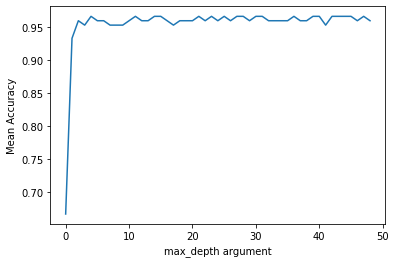

In [42]:
from IPython.display import display

df = pd.DataFrame(datasets[0]['result'])
display("Decision Tree:", df[(df['dataset']=='iris') & (df['classifier']=='decision tree')])
pruning_results = calculate_decision_tree_pruning_effect(datasets[0]['name'], datasets[0]['data'], datasets[0]['target'])
pruning_diagram = pruning_results['mean_accuracy'].plot.line()
pruning_diagram.set(xlabel = 'max_depth argument', ylabel= 'Mean Accuracy')
plt.show()

##### Random Forests
Random Forest exhibit good results for the Iris dataset, with mean accuracy levels similar to the results of "regular" decision trees, irrespective of the number of estimators applied:

In [ ]:
from IPython.display import display

df = pd.DataFrame(datasets[0]['result'])
display("Random Forest Results:", df[(df['dataset']=='iris') & (df['classifier']=='Random Forest')])


##### Supported Vector Machines

SVMs indicate good results for classifying the Iris dataset.

As can be seen below, both SVC and linear SVC yield good results, with 96%, respective 93% mean accuracy, and hence exhibit similar accuracy to the other classifiers used.

In [53]:
from IPython.display import display

df = pd.DataFrame(datasets[0]['result'])
display("SVM:", df[(df['dataset']=='iris') & (df['classifier']=='svm')])

'SVM:'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
17,iris,svm,SVC(max_iter=10000),0.966667,0.968485,0.966667,m: 0.9666666666666666 std: 0.02108185106778919,m: 0.9684848484848484 std: 0.0211340554838336,m: 0.9666666666666666 std: 0.021081851067789228
18,iris,svm,LinearSVC(max_iter=10000),0.933333,0.936768,0.933333,m: 0.9333333333333332 std: 0.036514837167011066,m: 0.9367676767676768 std: 0.037824742588988935,m: 0.9333333333333332 std: 0.036514837167011066


### Digits Dataset

'digits'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,digits,knn,KNeighborsClassifier(n_neighbors=1),0.964393,0.966470,0.964336,m: 0.9643933766635715 std: 0.011838424332891945,m: 0.966469548788538 std: 0.010632112151894059,m: 0.964336033512504 std: 0.011757226426753463
1,digits,knn,KNeighborsClassifier(n_neighbors=2),0.967171,0.968967,0.966957,m: 0.9671711544413494 std: 0.0061807234218177465,m: 0.9689673105288057 std: 0.005663822635776744,m: 0.9669567214273098 std: 0.0060744453248457175
2,digits,knn,KNeighborsClassifier(n_neighbors=3),0.966065,0.967450,0.965924,m: 0.9660646858557721 std: 0.009667874607068043,m: 0.9674502552623923 std: 0.009018588947318053,m: 0.9659241173947055 std: 0.009667378432553301
3,digits,knn,KNeighborsClassifier(n_neighbors=4),0.963841,0.966078,0.963575,m: 0.9638409161250386 std: 0.010945532623198,m: 0.9660776544299914 std: 0.009757692838089959,m: 0.9635748353395412 std: 0.01097966879217311
4,digits,knn,KNeighborsClassifier(),0.962728,0.964711,0.962557,m: 0.9627282575054161 std: 0.011168537355954218,m: 0.9647105099179404 std: 0.010266960336583798,m: 0.9625573220279102 std: 0.011176822445975412
5,digits,knn,KNeighborsClassifier(n_neighbors=6),0.959386,0.961224,0.959176,m: 0.9593856391210152 std: 0.010612016344327235,m: 0.961224271301029 std: 0.009721441327897259,m: 0.9591755116461 std: 0.010552036837323654
6,digits,knn,KNeighborsClassifier(n_neighbors=7),0.959946,0.961718,0.959763,m: 0.9599458372021046 std: 0.015059089584590093,m: 0.9617184051471506 std: 0.013821633585571631,m: 0.9597628132334014 std: 0.015061302477161276
7,digits,knn,KNeighborsClassifier(n_neighbors=8),0.958276,0.960109,0.958079,m: 0.9582760755184154 std: 0.014579790973465996,m: 0.960108921624704 std: 0.013444993062790362,m: 0.9580793398440457 std: 0.014508223803373129
8,digits,knn,KNeighborsClassifier(n_neighbors=9),0.956611,0.958885,0.956381,m: 0.9566109563602601 std: 0.01688704976398654,m: 0.9588846074758639 std: 0.01509933407533814,m: 0.956380927145633 std: 0.01680086257941144
9,digits,perceptron,Perceptron(),0.889850,0.903112,0.889553,m: 0.8898498916744042 std: 0.0372568973027817,m: 0.9031117904416195 std: 0.030180757216644268,m: 0.889553082494259 std: 0.03684074402780773


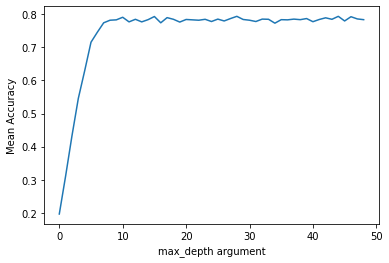

In [43]:
from IPython.display import display

display(datasets[1]['name'], datasets[1]['result'])

#### Reporting of New Findings for Exercise 4

##### Decision Trees And Decision Tree Pruning
As can be seen below, decision trees indicate sufficient levels of accuracy with 78% for an unpruned decision tree.

As for the prepruning related results:

Iteration over max depth values show, that these levels of accuracy are already reached at a maximum depth of 8.

Additionally, similar to the Iris dataset when prepruning based on min leaf size (50 samples per leaf), we see a limited degradation of accuracy (69%) with a minimum sample size of 50 samples per leaf. This is again expected, because although the sample size is higher than for the Iris dataset, so is the number of classes.

'Decision Tree:'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
10,digits,decision tree,DecisionTreeClassifier(),0.778004,0.790255,0.777996,m: 0.7780037140204271 std: 0.04144834310953494,m: 0.7902551278130012 std: 0.03296619785486468,m: 0.7779960128195422 std: 0.04087708603385885
11,digits,decision tree,DecisionTreeClassifier(max_depth=5),0.631131,0.683917,0.631631,m: 0.6311312287217581 std: 0.07808549850621432,m: 0.683916731786297 std: 0.042129128243631284,m: 0.6316305296893533 std: 0.0777224164231898
12,digits,decision tree,DecisionTreeClassifier(min_samples_leaf=50),0.698406,0.719580,0.6985,m: 0.6984060662333643 std: 0.01867382502523361,m: 0.7195803247084644 std: 0.016551416642186505,m: 0.6985002902061724 std: 0.018302651328836995


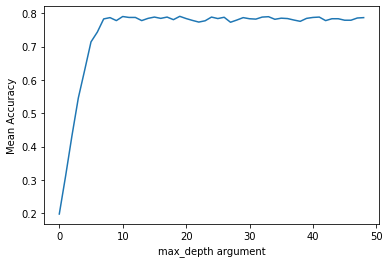

In [44]:
from IPython.display import display

df = pd.DataFrame(datasets[1]['result'])
display("Decision Tree:", df[(df['dataset']=='digits') & (df['classifier']=='decision tree')])
pruning_results = calculate_decision_tree_pruning_effect(datasets[1]['name'], datasets[1]['data'], datasets[1]['target'])
pruning_diagram = pruning_results['mean_accuracy'].plot.line()
pruning_diagram.set(xlabel = 'max_depth argument', ylabel= 'Mean Accuracy')
plt.show()

##### Random Forests
Random Forest exhibit good results for the digits dataset, with mean accuracy levels exceeding the results of "regular" decision trees, irrespective of the number of estimators applied:

In [45]:
from IPython.display import display

df = pd.DataFrame(datasets[1]['result'])
display("Random Forest Results:", df[(df['dataset']=='digits') & (df['classifier']=='Random Forest')])

'Random Forest Results:'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
13,digits,Random Forest,RandomForestClassifier(n_estimators=10),0.942761,0.942761,-,-,-,-
14,digits,Random Forest,RandomForestClassifier(n_estimators=60),0.973064,0.973064,-,-,-,-
15,digits,Random Forest,RandomForestClassifier(n_estimators=110),0.983165,0.983165,-,-,-,-
16,digits,Random Forest,RandomForestClassifier(n_estimators=160),0.978114,0.978114,-,-,-,-


##### Supported Vector Machines

SVMs indicate good results for classifying the Iris dataset.

As can be seen below, both SVC and linear SVC yield good results, with 94%, respective 91% mean accuracy, and hence exhibit similar accuracy to the other classifiers used.

In [52]:
from IPython.display import display

df = pd.DataFrame(datasets[1]['result'])
display("SVM:", df[(df['dataset']=='digits') & (df['classifier']=='svm')])

'SVM:'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
17,digits,svm,SVC(max_iter=10000),0.949362,0.955229,0.949392,m: 0.9493624264933457 std: 0.011018465556466121,m: 0.9552289365925759 std: 0.010570091006652111,m: 0.949391727862316 std: 0.011000834663817082
18,digits,svm,LinearSVC(max_iter=10000),0.910419,0.913420,0.910407,m: 0.9104193748065615 std: 0.02873450607706451,m: 0.9134203942648653 std: 0.025716775134242108,m: 0.910407020465844 std: 0.028480590894436993


### Music Dataset

#### Effect of Feature Extraction Approaches
Classification results of the music dataset clearly show the impact of the applied approach used for feature extraction on classification success:

With relatively "low level" approaches such as beats per minute analysis, classification yields limited results, irrespective of the classifier applied.
By using data that is already providing some aggregation on this data, results can be improved slightly although still at a very low level.

However, with feature extraction strategies that more closely resemble to human approaches to "decoding" music, such as chroma analysis or MFCC, results of subsequent classification can be improved considerably across almost all classifiers used.

#### BPM
As already stated above, classification success for the BPM dataset was limited with precision and accuracy ratings remaining under 25% for all classifiers.
None of the classifiers used exhibited better results which indicates that the issue is related to feature extraction.

Decision tree based classifiers exhibited the best results as well as supported vector machines.

As for the decision tree classifiers used, the effect of the max_depth argument exhibited to be non linear, which again hints at a non ideal feature extraction strategy.

In [ ]:
from IPython.display import display

display(datasets[2]['name'], datasets[2]['result'])
pruning_results = calculate_decision_tree_pruning_effect(datasets[2]['name'], datasets[2]['data'], datasets[2]['target'])
pruning_diagram = pruning_results['mean_accuracy'].plot.line()
pruning_diagram.set(xlabel = 'max_depth argument', ylabel= 'Mean Accuracy')
plt.show()

#### BPM Statistics
As for classification of BPM based statistics rather than raw BPM data results improved in a limited matter across all applied classifiers.

Random Forest Classifiers applied yielded results of up to 43% accuracy, SVM (SVC) also yielded comparable results.
Hence providing aggregated data rather than only raw BPM input significantly improved classification results

'data_bpm_statistics'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=1),0.178000,0.173767,0.178,m: 0.17800000000000002 std: 0.04118252056394801,m: 0.17376741970582327 std: 0.036023601761846914,m: 0.178 std: 0.04118252056394799
1,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=2),0.138000,0.133715,0.138,m: 0.13799999999999998 std: 0.026381811916545837,m: 0.1337151397993633 std: 0.024109830958204244,m: 0.13799999999999998 std: 0.026381811916545837
2,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=3),0.140000,0.153674,0.14,m: 0.13999999999999999 std: 0.03860051813123756,m: 0.15367377268569857 std: 0.05150245283865464,m: 0.13999999999999999 std: 0.03860051813123756
3,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=4),0.167000,0.180485,0.167,m: 0.16699999999999998 std: 0.025999999999999995,m: 0.18048488087861791 std: 0.034628739473841944,m: 0.16699999999999998 std: 0.026000000000000002
4,data_bpm_statistics,knn,KNeighborsClassifier(),0.165000,0.177439,0.165,m: 0.16499999999999998 std: 0.03162277660168379,m: 0.1774385807725894 std: 0.03591252241507328,m: 0.16499999999999998 std: 0.031622776601683784
5,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=6),0.160000,0.164632,0.16,m: 0.16 std: 0.03687817782917155,m: 0.16463188131357623 std: 0.04564480654130463,m: 0.16 std: 0.03687817782917154
6,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=7),0.149000,0.151005,0.149,m: 0.149 std: 0.032310988842807024,m: 0.15100503776250215 std: 0.04092169861213397,m: 0.14899999999999997 std: 0.03231098884280702
7,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=8),0.154000,0.157676,0.154,m: 0.154 std: 0.03733630940518894,m: 0.15767623487441648 std: 0.052027875458418915,m: 0.15400000000000003 std: 0.037336309405188936
8,data_bpm_statistics,knn,KNeighborsClassifier(n_neighbors=9),0.149000,0.145652,0.149,m: 0.149 std: 0.03337663853655727,m: 0.14565183823246938 std: 0.040774539240353666,m: 0.149 std: 0.03337663853655727
9,data_bpm_statistics,perceptron,Perceptron(),0.103000,0.019136,0.103,m: 0.10300000000000001 std: 0.006782329983125268,m: 0.01913565471960827 std: 0.004814050128224503,m: 0.10300000000000001 std: 0.0067823299831252645


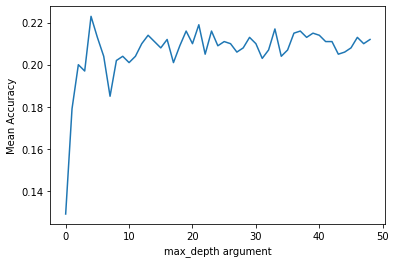

In [48]:
from IPython.display import display

display(datasets[3]['name'], datasets[3]['result'])
pruning_results = calculate_decision_tree_pruning_effect(datasets[3]['name'], datasets[3]['data'], datasets[3]['target'])
pruning_diagram = pruning_results['mean_accuracy'].plot.line()
pruning_diagram.set(xlabel = 'max_depth argument', ylabel= 'Mean Accuracy')
plt.show()

#### Chroma
When using chroma analysis as a foundation for feature extraction, subsequent classification showed similar results to classification based on BPM feature extraction.

Random Forest and SVM both yielded 43% of accuracy.

'data_chroma'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,data_chroma,knn,KNeighborsClassifier(n_neighbors=1),0.307000,0.308005,0.307,m: 0.307 std: 0.019899748742132416,m: 0.3080048236025353 std: 0.02220916489061227,m: 0.30699999999999994 std: 0.01989974874213241
1,data_chroma,knn,KNeighborsClassifier(n_neighbors=2),0.310000,0.316162,0.31,m: 0.31 std: 0.026832815729997468,m: 0.31616150116887465 std: 0.05999375578145055,m: 0.31000000000000005 std: 0.02683281572999747
2,data_chroma,knn,KNeighborsClassifier(n_neighbors=3),0.310000,0.319674,0.31,m: 0.31 std: 0.026267851073127395,m: 0.31967440294641614 std: 0.026859914568178926,m: 0.30999999999999994 std: 0.026267851073127405
3,data_chroma,knn,KNeighborsClassifier(n_neighbors=4),0.325000,0.325734,0.325,m: 0.325 std: 0.028809720581775857,m: 0.3257343728604093 std: 0.01832661163757916,m: 0.325 std: 0.028809720581775857
4,data_chroma,knn,KNeighborsClassifier(),0.328000,0.324824,0.328,m: 0.32799999999999996 std: 0.020880613017821098,m: 0.32482377983108723 std: 0.02080476464509703,m: 0.328 std: 0.020880613017821077
5,data_chroma,knn,KNeighborsClassifier(n_neighbors=6),0.340000,0.337331,0.34,m: 0.33999999999999997 std: 0.033166247903554,m: 0.3373306080103687 std: 0.030417025521870235,m: 0.33999999999999997 std: 0.03316624790355399
6,data_chroma,knn,KNeighborsClassifier(n_neighbors=7),0.332000,0.323215,0.332,m: 0.33199999999999996 std: 0.027856776554368242,m: 0.32321466270189647 std: 0.026764701956724146,m: 0.33199999999999996 std: 0.027856776554368242
7,data_chroma,knn,KNeighborsClassifier(n_neighbors=8),0.335000,0.324445,0.335,m: 0.335 std: 0.03146426544510455,m: 0.32444484953141706 std: 0.01994329938378952,m: 0.335 std: 0.03146426544510453
8,data_chroma,knn,KNeighborsClassifier(n_neighbors=9),0.333000,0.319738,0.333,m: 0.333 std: 0.03487119154832538,m: 0.3197375555776478 std: 0.02488260971727399,m: 0.333 std: 0.034871191548325374
9,data_chroma,perceptron,Perceptron(),0.231000,0.254747,0.231,m: 0.23099999999999996 std: 0.055982140009113626,m: 0.25474749345422004 std: 0.057043450391375504,m: 0.23099999999999996 std: 0.05598214000911363


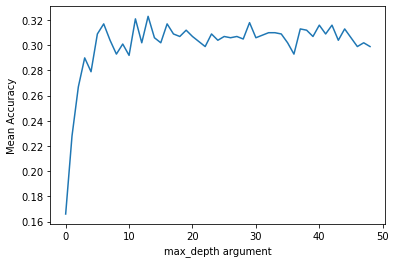

In [49]:
from IPython.display import display

display(datasets[4]['name'], datasets[4]['result'])
pruning_results = calculate_decision_tree_pruning_effect(datasets[4]['name'], datasets[4]['data'], datasets[4]['target'])
pruning_diagram = pruning_results['mean_accuracy'].plot.line()
pruning_diagram.set(xlabel = 'max_depth argument', ylabel= 'Mean Accuracy')
plt.show()

#### MFCC
Running classification on Mel Frequency Cepstral Coefficients rather than BPM improved classification results significantly: SVM was able to accurately predict 60% of test sets and Random Forest classifiers even were able to accurately predict 2/3s of the test samples.

The MFCC transformation could show that transformations like MFCC that are aimed at extracting features in a way that is actually similar to the human analysis of language or music yield far better results in classification tasks than feature extraction approaches that focus solely on physical attributes of the audio files.

'data_mfcc'

,dataset,classifier,arguments,mean_accuracy,mean_precision,mean_recall,accuracy,precision,recall
0,data_mfcc,knn,KNeighborsClassifier(n_neighbors=1),0.319000,0.346639,0.319,m: 0.319 std: 0.04199999999999999,m: 0.3466391133965758 std: 0.04460203197145104,m: 0.319 std: 0.04199999999999998
1,data_mfcc,knn,KNeighborsClassifier(n_neighbors=2),0.311000,0.337969,0.311,m: 0.31100000000000005 std: 0.033970575502926044,m: 0.3379689050404274 std: 0.04557085367206833,m: 0.31099999999999994 std: 0.03397057550292604
2,data_mfcc,knn,KNeighborsClassifier(n_neighbors=3),0.325000,0.359320,0.325,m: 0.32499999999999996 std: 0.02428991560298224,m: 0.35932029681793215 std: 0.02668603943635205,m: 0.325 std: 0.024289915602982236
3,data_mfcc,knn,KNeighborsClassifier(n_neighbors=4),0.321000,0.338612,0.321,m: 0.321 std: 0.03666060555964671,m: 0.3386118452416282 std: 0.03347485271320054,m: 0.321 std: 0.03666060555964671
4,data_mfcc,knn,KNeighborsClassifier(),0.325000,0.343799,0.325,m: 0.325 std: 0.03646916505762095,m: 0.34379852010792245 std: 0.03260042563779909,m: 0.325 std: 0.03646916505762094
5,data_mfcc,knn,KNeighborsClassifier(n_neighbors=6),0.330000,0.341977,0.33,m: 0.32999999999999996 std: 0.04764451699828638,m: 0.34197742926224733 std: 0.0436928659835618,m: 0.32999999999999996 std: 0.047644516998286375
6,data_mfcc,knn,KNeighborsClassifier(n_neighbors=7),0.332000,0.343382,0.332,m: 0.33199999999999996 std: 0.033105890714493706,m: 0.3433822620055794 std: 0.03000526530120327,m: 0.332 std: 0.033105890714493685
7,data_mfcc,knn,KNeighborsClassifier(n_neighbors=8),0.332000,0.349196,0.332,m: 0.33199999999999996 std: 0.0331058907144937,m: 0.3491957134344011 std: 0.04118405747504487,m: 0.33199999999999996 std: 0.03310589071449373
8,data_mfcc,knn,KNeighborsClassifier(n_neighbors=9),0.317000,0.327029,0.317,m: 0.317 std: 0.045343136195018535,m: 0.3270288351417535 std: 0.04351904792762874,m: 0.317 std: 0.045343136195018535
9,data_mfcc,perceptron,Perceptron(),0.229000,0.271794,0.229,m: 0.229 std: 0.03878143885933062,m: 0.2717937106607759 std: 0.04639412218691525,m: 0.229 std: 0.03878143885933062


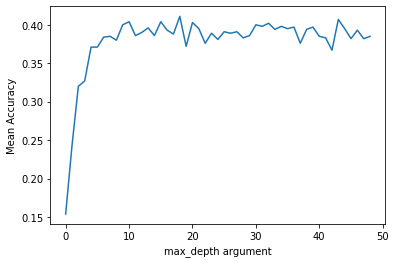

In [50]:
from IPython.display import display

display(datasets[5]['name'], datasets[5]['result'])
pruning_results = calculate_decision_tree_pruning_effect(datasets[5]['name'], datasets[5]['data'], datasets[5]['target'])
pruning_diagram = pruning_results['mean_accuracy'].plot.line()
pruning_diagram.set(xlabel = 'max_depth argument', ylabel= 'Mean Accuracy')
plt.show()

## Additional Analysis on Song Level

/tmp/mp3/rock/rock.00098.mp3
Showing demo feature extraction on song /tmp/mp3/rock/rock.00098.mp3
The song has [112.34714674] beats per minute


/home/andi/PycharmProjects/tw_mle_exercise4/venv/lib64/python3.8/site-packages/librosa/core/spectrum.py:1702: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


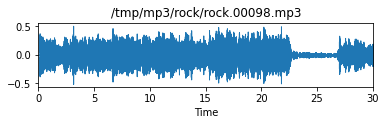

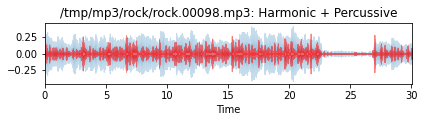

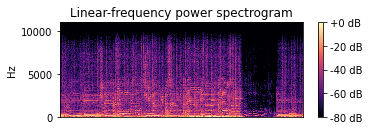

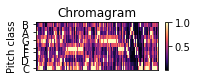

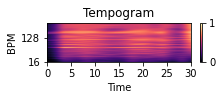

In [51]:
import matplotlib.pyplot as plt
from librosa import display
import librosa
import numpy as np

demoSongName = fileNames[1]
demoSongPath = imagePath + demoSongName
#demoSongPath = demoSongPath.replace("\\", "/")
print(demoSongPath)
print ("Showing demo feature extraction on song " + demoSongPath)

y, sr = librosa.load(demoSongPath)

# compute the tempo
onset_env = librosa.onset.onset_strength(y, sr=sr)
tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
print ("The song has " + str(tempo) + " beats per minute")

# plot the wave form
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title(demoSongPath)

y_harm, y_perc = librosa.effects.hpss(y)
plt.figure()
plt.subplot(3, 1, 3)
librosa.display.waveplot(y_harm, sr=sr, alpha=0.25)
librosa.display.waveplot(y_perc, sr=sr, color='r', alpha=0.5)
plt.title(demoSongPath + ': Harmonic + Percussive')
plt.tight_layout()

# Plot the power spectrum
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

# Plot Chroma
plt.figure()
C = librosa.feature.chroma_cqt(y=y, sr=sr)
plt.subplot(4, 2, 5)
librosa.display.specshow(C, y_axis='chroma')
plt.colorbar()
plt.title('Chromagram')

# Plot tempogram
plt.figure()
plt.subplot(4, 2, 8)
Tgram = librosa.feature.tempogram(y=y, sr=sr)
librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
plt.colorbar()
plt.title('Tempogram')
plt.tight_layout()

plt.show()